In [1]:
# !pip install git+https://github.com/huggingface/transformers accelerate
# !pip install qwen-vl-utils[decord]==0.0.8


In [2]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2.5-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

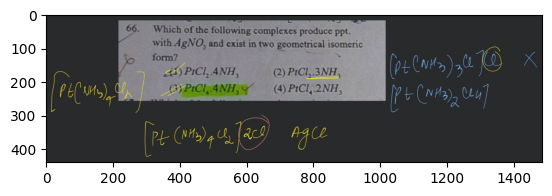

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('slide.jpeg')
imgplot = plt.imshow(img)
plt.show()

In [3]:
%%time
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "slide.jpeg",
            },
            {"type": "text", "text": "Which of the option mentioned in the image is the correct option for the question asked?"},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

["The question asks which of the following complexes produce a precipitate (ppt) with AgNO₃ and exist in two geometrical isomeric forms.\n\nLet's analyze each option:\n\n1. **PtCl₂·4NH₃**\n   - This complex has 2 chloride ligands and 4 ammonia ligands.\n   - It does not form a precipitate with AgNO₃ because it does not have any free chloride ions that can react with silver ions to form a precipitate of AgCl.\n   - It also does not exist in two geometrical isomers because it has a square planar geometry, which does"]
CPU times: user 2min 15s, sys: 6.04 s, total: 2min 21s
Wall time: 2min 45s


In [6]:
output_text[0].split("\n")

['The question asks which of the following complexes produce a precipitate (ppt) with AgNO₃ and exist in two geometrical isomeric forms.',
 '',
 "Let's analyze each option:",
 '',
 '1. **PtCl₂·4NH₃**',
 '   - This complex has 2 chloride ligands and 4 ammonia ligands.',
 '   - It does not form a precipitate with AgNO₃ because it does not have any free chloride ions that can react with silver ions to form a precipitate of AgCl.',
 '   - It also does not exist in two geometrical isomers because it has a square planar geometry, which does']